In [4]:
import sys
sys.path.append('../')

In [5]:
import pickle
import numpy as np
import pandas as po
from tqdm import tqdm
import multiprocessing
import matplotlib.pyplot as plt

In [6]:
from scipy.interpolate import interp1d
from numpy import arange, exp

In [7]:
from filepaths import fp

In [5]:
df = po.read_csv('../'+fp.imputation_raw)

In [6]:
df

,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,2014/1/17,2014/1/18,...,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9,num_zeros,FLAG
0,10.88,5.40,6.130000,11.79,11.560000,17.000000,12.200000,13.830000,8.970,0.17,...,8.16,7.91,9.550000,10.550000,10.00,11.250000,9.260000,9.25,205,0
1,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000,0.00,...,41.26,20.79,44.250000,36.630000,40.87,32.580000,34.340000,25.62,517,1
2,12.53,11.38,10.230000,5.04,6.790000,7.750000,5.840000,6.140000,4.775,3.41,...,19.17,25.94,19.150000,16.910000,23.93,24.120000,16.810000,13.94,277,0
3,6.77,6.18,6.600000,6.56,6.180000,6.180000,6.180000,6.560000,6.820,6.54,...,11.62,12.16,13.590000,14.540000,12.63,12.310000,11.370000,11.23,0,0
4,0.00,8.47,8.669468,7.66,8.669468,8.669468,8.669468,8.669468,6.860,5.65,...,1.77,1.40,1.300000,0.980000,1.91,1.500000,1.080000,1.12,217,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24363,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000,0.00,...,1.32,0.64,1.640000,0.460000,0.50,0.730000,0.360000,0.67,128,0
24364,10.11,7.75,9.000000,7.59,6.140000,7.740000,7.840000,21.251005,6.800,9.78,...,15.39,6.82,21.251005,16.920000,15.77,21.251005,21.251005,15.56,8,0
24365,4.15,2.51,2.470000,2.31,4.015000,5.720000,3.320000,2.040000,2.540,2.89,...,5.76,5.28,4.430000,5.970000,5.95,4.190000,2.520000,5.91,0,0
24366,0.44,0.27,0.560000,0.24,0.190000,0.105000,0.020000,0.010000,0.150,0.29,...,0.07,0.16,0.116667,0.073333,0.03,0.100000,0.100000,0.08,149,0


In [7]:
def find_gaps(x):
    seq = False
    missing_seqs = []
    seq_start_idx = -1
    for i in range(len(x)):
        if seq == False and x[i] == 0:
            seq = True
            seq_start_idx = i
        
        elif seq == True and x[i] != 0:
            seq = False
            if seq_start_idx == -1:
                raise
            missing_seqs.append((seq_start_idx, i))
            seq_start_idx = -1
    
    return missing_seqs

In [8]:
def interpolate_gaps(x):
    x_filled = x.copy()
    missing_seqs = find_gaps(x)
    
    for seq in missing_seqs:
        len_gap = seq[1] - seq[0]
        
        if seq[0]-len_gap < 0 and seq[1]+len_gap > len(x): # Gap at both ends. Ignore this row for now.
            continue
            
        elif seq[0]-len_gap < 0: # Gap at start only. Make interpolator from right and extrapolate to fill
            if seq[1]+2*len_gap < len(x):
                interpfunk = interp1d(list(range(seq[1], seq[1]+2*len_gap)), x[seq[1]:seq[1]+2*len_gap], fill_value='extrapolate') # Take twice as much from the available side (if possible)
               
            elif seq[1]+len_gap < len(x):
                interpfunk = interp1d(list(range(seq[1], seq[1]+len_gap)), x[seq[1]:seq[1]+len_gap], fill_value='extrapolate') 
                
            else:
                continue # Gap is too large. Ignore this row for now.
            
        elif seq[1]+len_gap > len(x): # Gap at end only. Make interpolator from left and extrapolate to fill
            if seq[0]-2*len_gap > 0:
                interpfunk = interp1d(list(range(seq[0]-2*len_gap, seq[0])), x[seq[0]-2*len_gap:seq[0]], fill_value='extrapolate')  # Take twice as much from the available side (if possible)
            
            elif seq[0]-len_gap > 0:
                interpfunk = interp1d(list(range(seq[0]-len_gap, seq[0])), x[seq[0]-len_gap:seq[0]], fill_value='extrapolate') 
            
            else:
                continue # Gap is too large. Ignore this row for now.
            
        else:
            interpfunk = interp1d(list(range(seq[0]-len_gap, seq[0])) + list(range(seq[1], seq[1]+len_gap)), x[seq[0]-len_gap:seq[0]] + x[seq[1]:seq[1]+len_gap]) 
    
        for i in range(len_gap):
            x_filled[seq[0]+i] = interpfunk(seq[0]+i).item()
            
    return x_filled

In [9]:
def impute_row(i):
    x = df.iloc[i][:-2].to_list()
    return interpolate_gaps(x)    

In [10]:
p = multiprocessing.Pool() 
new_rows = list(tqdm(p.imap(impute_row, list(range(len(df)))), total=len(df)))

100%|██████████| 24368/24368 [00:16<00:00, 1476.89it/s]


In [11]:
df_interp = po.DataFrame(new_rows)

In [12]:
df_interp.columns = df.columns[:-2]

In [13]:
df_interp

,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,2014/1/17,2014/1/18,...,2016/9/28,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9
0,10.880000,5.40,6.130000,11.79,11.560000,17.000000,12.200000,13.830000,8.970,0.17,...,5.44,9.17,8.16,7.91,9.550000,10.550000,10.00,11.250000,9.260000,9.25
1,-539.540000,-514.14,-488.740000,-463.34,-437.940000,-412.540000,-387.140000,-361.740000,-336.340,-310.94,...,33.46,20.48,41.26,20.79,44.250000,36.630000,40.87,32.580000,34.340000,25.62
2,12.530000,11.38,10.230000,5.04,6.790000,7.750000,5.840000,6.140000,4.775,3.41,...,16.62,16.45,19.17,25.94,19.150000,16.910000,23.93,24.120000,16.810000,13.94
3,6.770000,6.18,6.600000,6.56,6.180000,6.180000,6.180000,6.560000,6.820,6.54,...,5.84,7.10,11.62,12.16,13.590000,14.540000,12.63,12.310000,11.370000,11.23
4,8.270532,8.47,8.669468,7.66,8.669468,8.669468,8.669468,8.669468,6.860,5.65,...,3.06,2.84,1.77,1.40,1.300000,0.980000,1.91,1.500000,1.080000,1.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24363,13.050000,12.66,12.270000,11.88,11.490000,11.100000,10.710000,10.320000,9.930,9.54,...,0.50,0.62,1.32,0.64,1.640000,0.460000,0.50,0.730000,0.360000,0.67
24364,10.110000,7.75,9.000000,7.59,6.140000,7.740000,7.840000,21.251005,6.800,9.78,...,9.57,6.72,15.39,6.82,21.251005,16.920000,15.77,21.251005,21.251005,15.56
24365,4.150000,2.51,2.470000,2.31,4.015000,5.720000,3.320000,2.040000,2.540,2.89,...,2.93,4.75,5.76,5.28,4.430000,5.970000,5.95,4.190000,2.520000,5.91
24366,0.440000,0.27,0.560000,0.24,0.190000,0.105000,0.020000,0.010000,0.150,0.29,...,0.07,0.11,0.07,0.16,0.116667,0.073333,0.03,0.100000,0.100000,0.08


In [14]:
num_zeros = []
for i in tqdm(range(len(df_interp))):
    num_zeros.append(df_interp.iloc[i].to_list().count(0))

100%|██████████| 24368/24368 [00:02<00:00, 10062.41it/s]


In [15]:
df_interp['num_zeros'] = num_zeros

In [16]:
df_interp['num_zeros']

0        0
1        0
2        0
3        0
4        0
        ..
24363    0
24364    0
24365    0
24366    0
24367    0
Name: num_zeros, Length: 24368, dtype: int64

In [17]:
df['num_zeros']

0        205
1        517
2        277
3          0
4        217
        ... 
24363    128
24364      8
24365      0
24366    149
24367      2
Name: num_zeros, Length: 24368, dtype: int64

In [18]:
df_interp['FLAG'] = df['FLAG']

In [25]:
df_interp.to_csv('../' + fp.interp_imputed_df, index=False)

In [9]:
df = po.read_csv('../'+fp.imputation_raw)
df_interp = po.read_csv('../' + fp.interp_imputed_df)

In [10]:
i = 28

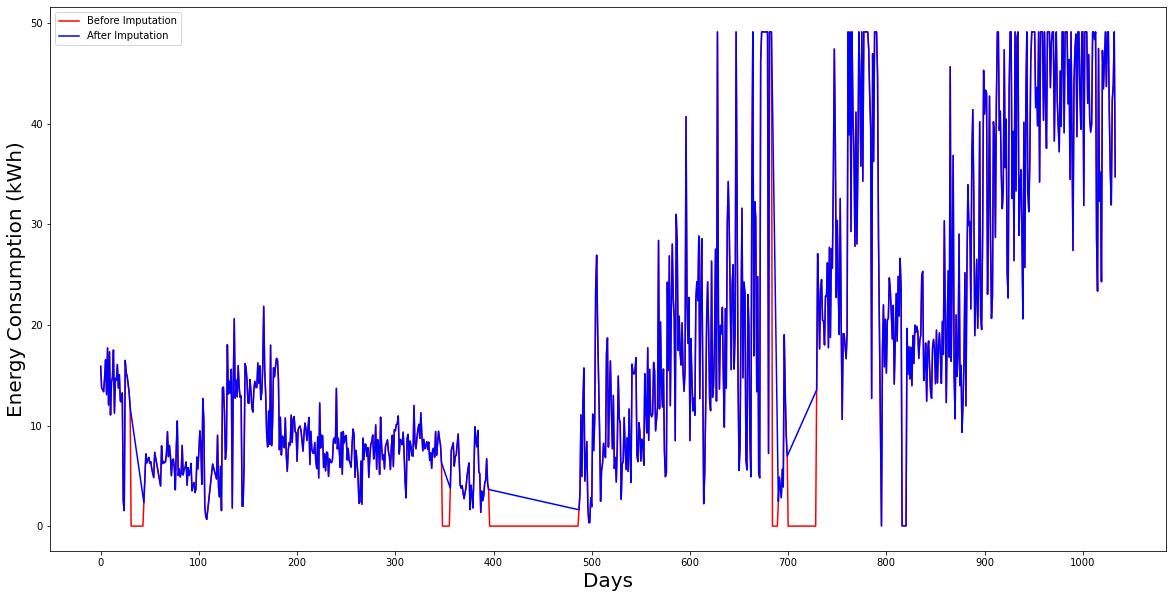

In [13]:
plt.figure(figsize=(20, 10))
plt.plot(df.iloc[i][:-2], color='red')
plt.plot(df_interp.iloc[i][:-2], color='blue')
plt.xticks(range(0, len(df.iloc[28][:-2]), 100), range(0, len(df.iloc[28][:-2]), 100)) 
plt.xlabel('Days', fontsize=20)
plt.ylabel('Energy Consumption (kWh)', fontsize=20)
plt.legend(['Before Imputation', 'After Imputation'])
plt.savefig('../plots/impute/interpolate.png')

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(df.iloc[28][:-2], color='red')
plt.plot(df_edtwbi_impute.iloc[28][:-2], color='blue')
plt.xticks(range(0, len(df.iloc[28][:-2]), 100), range(0, len(df.iloc[28][:-2]), 100)) 
plt.xlabel('Days', fontsize=20)
plt.ylabel('Energy Consumption (kWh)', fontsize=20)
plt.legend(['Before Imputation', 'After Imputation'])
plt.savefig('../plots/impute/eDTWBI.png')